# Outlier Detection Demo

In [1]:
import pandas as pd

In [3]:
df = pd.read_csv("nyc_taxi.csv", 
                 index_col='timestamp', 
                 parse_dates=True)
df.head()

,value
timestamp,
2014-07-01 00:00:00,10844
2014-07-01 00:30:00,8127
2014-07-01 01:00:00,6210
2014-07-01 01:30:00,4656
2014-07-01 02:00:00,3820


<Axes: xlabel='timestamp'>

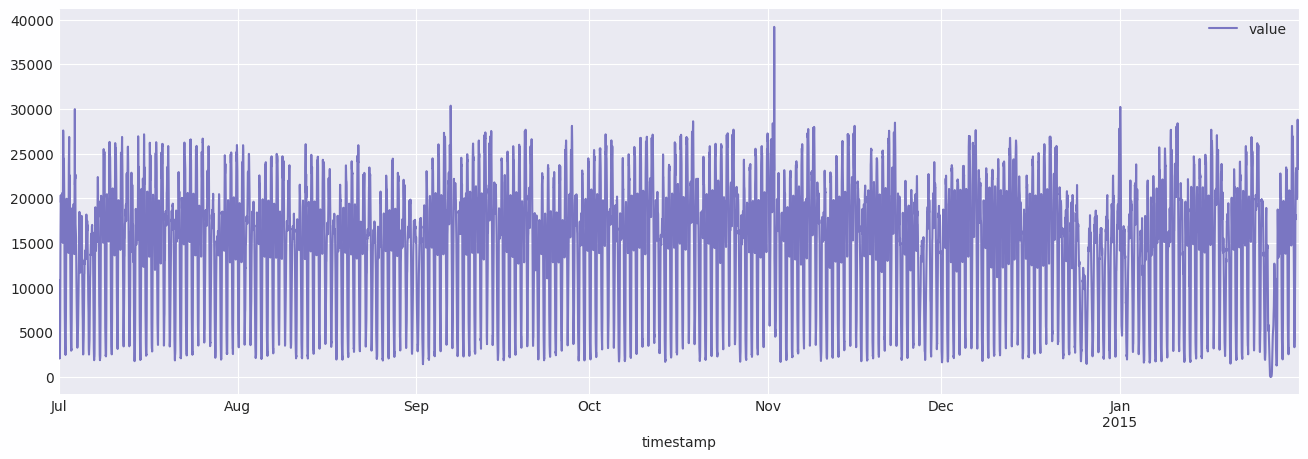

In [29]:
import matplotlib.pyplot as plt
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')
plt.rc("figure", figsize=(16, 5))
df.plot()

In [30]:
df.index.freq = '30min'
df.index

DatetimeIndex(['2014-07-01 00:00:00', '2014-07-01 00:30:00',
               '2014-07-01 01:00:00', '2014-07-01 01:30:00',
               '2014-07-01 02:00:00', '2014-07-01 02:30:00',
               '2014-07-01 03:00:00', '2014-07-01 03:30:00',
               '2014-07-01 04:00:00', '2014-07-01 04:30:00',
               ...
               '2015-01-31 19:00:00', '2015-01-31 19:30:00',
               '2015-01-31 20:00:00', '2015-01-31 20:30:00',
               '2015-01-31 21:00:00', '2015-01-31 21:30:00',
               '2015-01-31 22:00:00', '2015-01-31 22:30:00',
               '2015-01-31 23:00:00', '2015-01-31 23:30:00'],
              dtype='datetime64[ns]', name='timestamp', length=10320, freq='30min')

<Axes: xlabel='timestamp'>

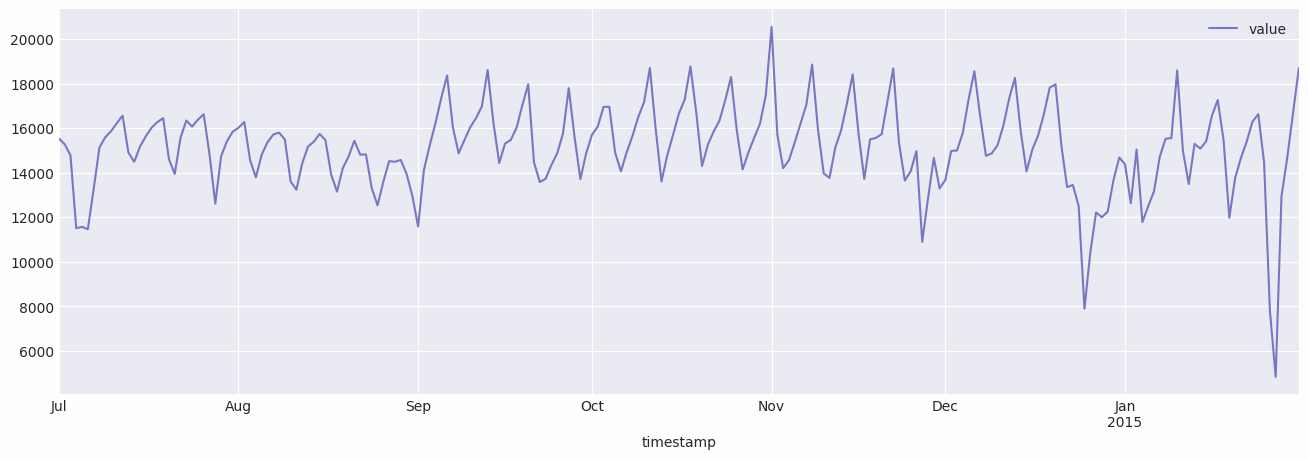

In [31]:
df_resampled = df.resample('d').mean() # average by day
df_resampled.plot()

In [32]:
# known outliers
nyc_dates =  [
        "2014-11-01",
        "2014-11-27",
        "2014-12-25",
        "2015-01-01",
        "2015-01-27"
]

In [33]:
known_outliers = df_resampled.loc[nyc_dates]

In [34]:
def plot_outliers(outliers, data, method='KNN', halignment='right', valignment='bottom', labels=False):
    
    fig, ax = plt.subplots(figsize=(10, 6))
        
    data.plot(ax=ax, alpha=0.6)
    
    # Plot outliers
    if labels:
        outliers.plot(ax=ax, style='rx', markersize=8, legend=False)
        
        # Add text labels for each outlier
        for idx, value in outliers['value'].items():
            ax.text(idx, value, f'{idx.date()}', 
                   horizontalalignment=halignment, 
                   verticalalignment=valignment)
    else:
        outliers.plot(ax=ax, style='rx', legend=False)
    
    ax.set_title(f'NYC Taxi - {method}')
    ax.set_xlabel('date')
    ax.set_ylabel('# of passengers')
    ax.legend(['nyc taxi', 'outliers'])
    
    plt.tight_layout()
    plt.show()

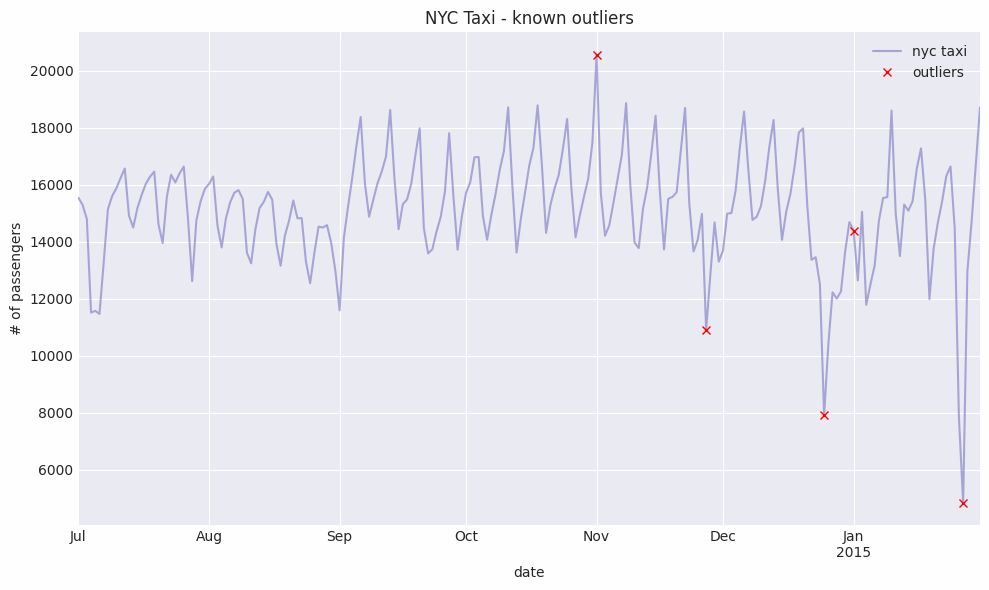

In [35]:
plot_outliers(known_outliers, df_resampled, "known outliers")

<Axes: ylabel='Count'>

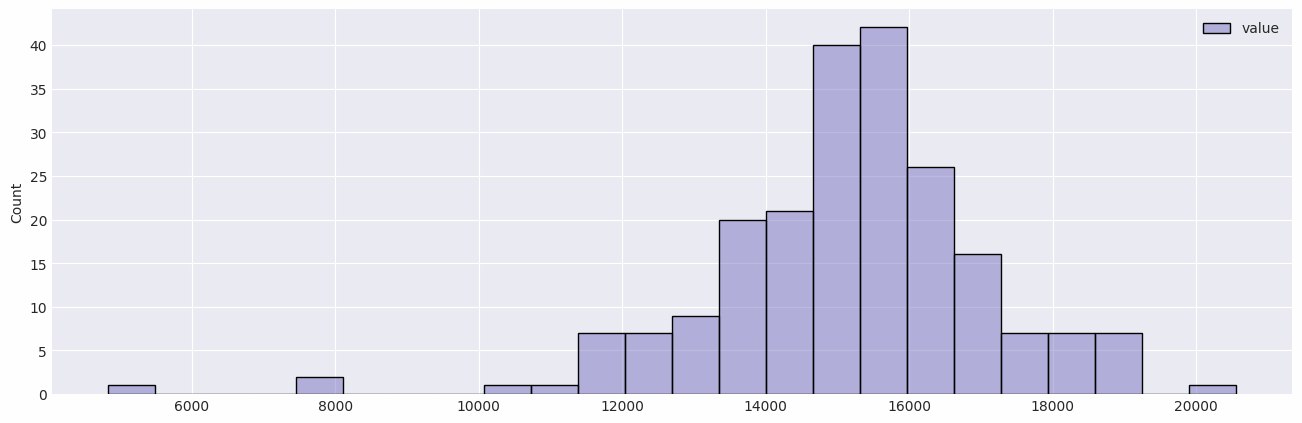

In [36]:
import seaborn as sns

sns.histplot(df_resampled)

<Axes: >

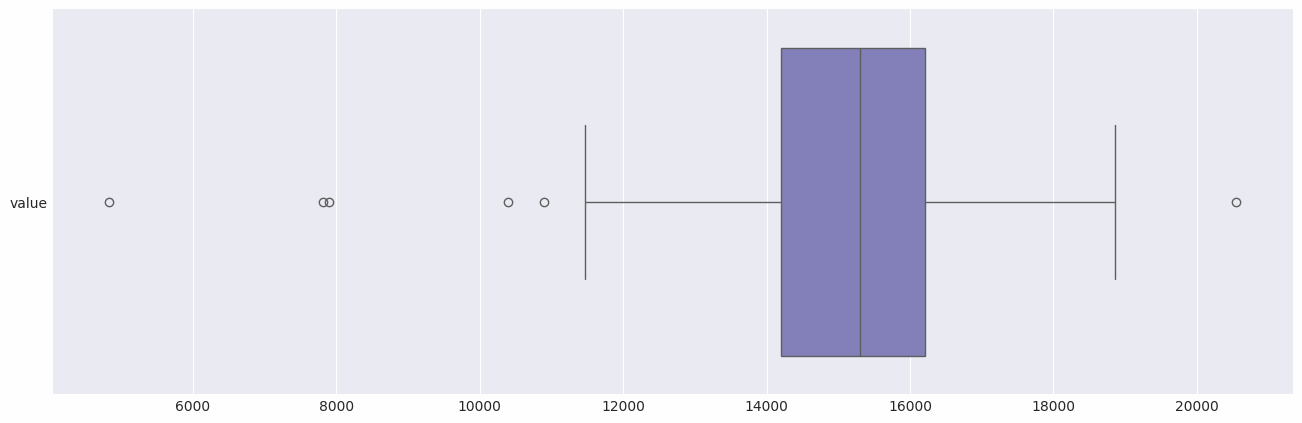

In [37]:
sns.boxplot(df_resampled, orient='h')

In [40]:
import numpy as np

q1, q3 = np.percentile(df_resampled, [25, 75])
IQR = q3 - q1
lower_fence = q1 - (1.5 * IQR)
upper_fence = q3 + (1.5 * IQR)

In [41]:
outliers = df_resampled[(df_resampled['value'] > upper_fence) | (df_resampled['value'] < lower_fence)]

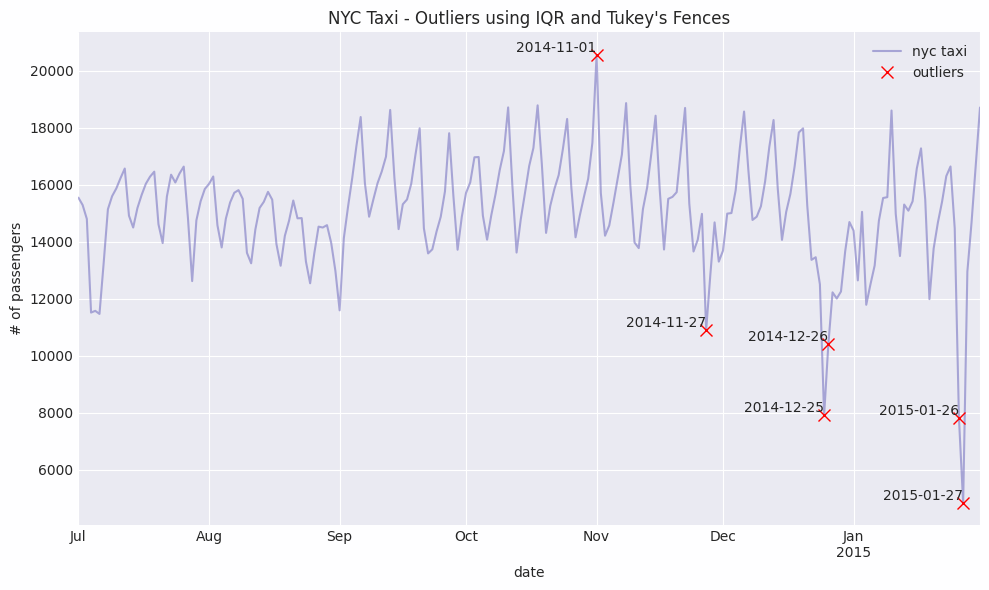

In [43]:
plot_outliers(outliers, df_resampled, "Outliers using IQR and Tukey's Fences", labels=True)

In [45]:
!uv pip install pyod -q

In [46]:
from pyod.models.knn import KNN
from pyod.models.iforest import IForest

In [47]:
iforest = IForest(contamination=0.03)

In [48]:
iforest.fit(df_resampled)

IForest(behaviour='old', bootstrap=False, contamination=0.03,
    max_features=1.0, max_samples='auto', n_estimators=100, n_jobs=1,
    random_state=None, verbose=0)

In [50]:
iforest_pred = pd.Series(iforest.predict(df_resampled), index=df_resampled.index)

/workspaces/4.TechCatalyst_DE_2025/dev7/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(


In [51]:
iforest_outliers = iforest_pred[iforest_pred == 1]
iforest_outliers = df_resampled.loc[iforest_outliers .index]

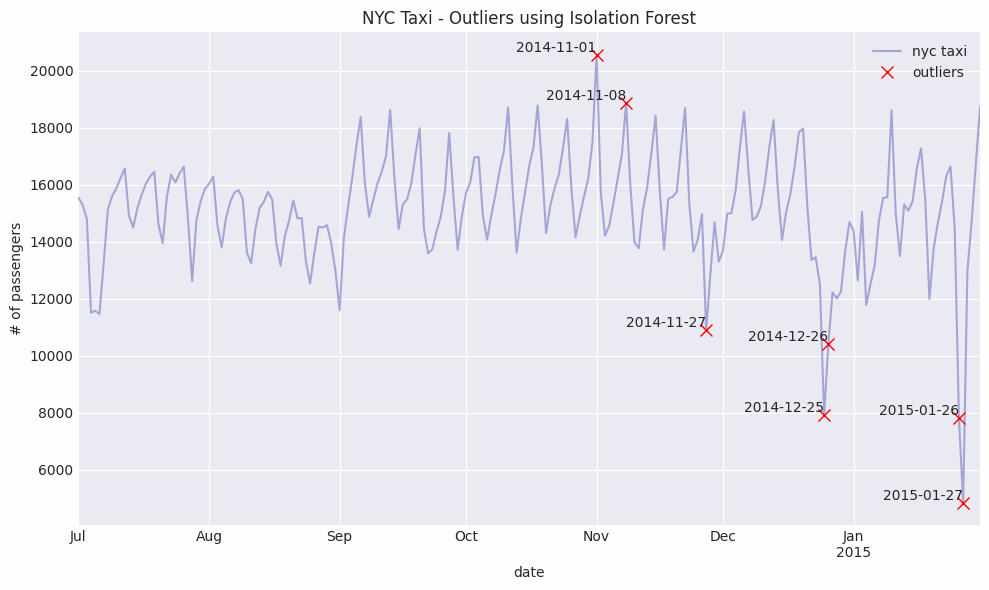

In [52]:
plot_outliers(iforest_outliers, df_resampled, "Outliers using Isolation Forest", labels=True)